# PySpark Machine Learning

## Library and Data Imports

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer, NGram
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import seaborn as sns

In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/ardit.baboci@ucalgary.ca/labelled_data_final.csv")

# Encode the labels into integers
label_stringIdx = StringIndexer(inputCol = "manual label", outputCol = "label")
model = label_stringIdx.fit(df1)
df_labelled = model.transform(df1)

# Split the dataset into training and testing sets
splits = df_labelled.randomSplit([0.8,0.2], seed = 42)
train = splits[0]
test = splits[1]

In [0]:
train.display()

_c0,id,Time of Creation,processed_sentence,tickers,manual label,label
0,abpq2d,2019-01-01 21:12,long dollarsign twtr dollarsign tickerplaceholder,SQ,Buy,1.0
1,ac1ox8,2019-01-02 21:00,sneak peek minussign tomorrow follow minussign dollarsign tickerplaceholder announcement,AAPL,Hold,0.0
10023,kb8mza,2020-12-11 11:47,tickerplaceholder highlight holiday sale updated early jan per cfo numberplaceholder percentsign short interest include huge short attack earnings numberplaceholder million share plussign minussign purchased today buy put holder borrow rate numberplaceholder percentsign short jan call going crey crey holding mix share call cash secured put plussign jan added today also note could get paid purchase tickerplaceholder,GME,Hold,0.0
10038,kb444z,2020-12-11 7:47,dollarsign numberplaceholder ath dollarsign numberplaceholder currently minussign dollarsign tickerplaceholder well undervalue relative ath minussign steel sector taking minussign news starting leak steel dynamic announced body maker new tesla truck proof wwwkiiitvcomarticlenewslocal minussign billion minussign dollar minussign steel minussign dynamic minussign plant minussign minussign sinton minussign set minussign minussign minussign minussign minussign running minussign minussign fall minussign minussign minussign numberplaceholder minussign dbd minussign numberplaceholder minussign dcdf minussign news really matriculated broadly retail crowd yet follow meme stock back time high asap check call put volume next week people catching theory take minute,STLD,Hold,0.0
10049,kayned,2020-12-11 1:04,case bankruptcy scenario short squeeze occur probably scenario tickerplaceholder ultimately face bankruptcy,GME,Hold,0.0
10106,kbnqh0,2020-12-12 4:35,call tickerplaceholder everyone,NFLX,Buy,1.0
10156,kchcs1,2020-12-13 12:52,tickerplaceholder tickerplaceholder disclaimer old conservative portfolio tickerplaceholder minussign true simple,PLTR,Hold,0.0
10162,kceuwo,2020-12-13 10:42,tickerplaceholder hiring rocketemoji rocketemoji rocketemoji rocketemoji,PLTR,Buy,1.0
10245,ke1sfb,2020-12-15 20:57,guy help pump tickerplaceholder dollarsign numberplaceholder get logo tatted dick,PLTR,Hold,0.0
10257,kdyhrf,2020-12-15 17:40,tickerplaceholder flying car future self driving car real,VLDR,Hold,0.0


## Creating the Machine Learning Pipeline

In [0]:
def MLPipeline(train, test, model, ngram, tfidf):
    
    # Create the training pipeline
    if tfidf == True:
        tokenizer = Tokenizer(inputCol="processed_sentence", outputCol="words")
        ngram = NGram(n = ngram, inputCol=tokenizer.getOutputCol(), outputCol="words_ngram")
        countVectorizer = CountVectorizer(inputCol=ngram.getOutputCol(), outputCol="words_hashed")
        idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="features")
        pipeline = Pipeline(stages=[tokenizer, ngram, countVectorizer, idf, model])
    else:
        tokenizer = Tokenizer(inputCol="processed_sentence", outputCol="words")
        ngram = NGram(n = ngram, inputCol=tokenizer.getOutputCol(), outputCol="words_ngram")
        countVectorizer = CountVectorizer(inputCol=ngram.getOutputCol(), outputCol="features")
        pipeline = Pipeline(stages=[tokenizer, ngram, countVectorizer, model])

    model = pipeline.fit(train)
    prediction = model.transform(test)

    predictions = list(prediction.select(prediction.prediction).toPandas()['prediction'])
    labels = list(prediction.select(prediction.label).toPandas()['label'])
    
    predictionAndLabels = spark.createDataFrame(zip(predictions, labels), ["prediction", "label"])

    metrics = MulticlassMetrics(predictionAndLabels.rdd)

    print("Confusion Matrix:")
    print(metrics.confusionMatrix().toArray())
    print()

    print("Weighted Performance Metrics:")
    print(f"Precision : {metrics.weightedPrecision}")
    print(f"Recall : {metrics.weightedRecall}")
    print(f"F1-score : {metrics.weightedFMeasure()}")



## Running Various Models Through the Machine Learning Pipeline

### Logistic Regression

##### Bag of Words

In [0]:
# regParam = 0, fitIntercept = False, ngram = 1, using Bag of Words
model = LogisticRegression(regParam = 0, fitIntercept = False)
MLPipeline(train, test, model, 1, False)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[92. 52. 32.]
 [ 9. 67. 10.]
 [ 5.  4. 22.]]

Weighted Performance Metrics:
Precision : 0.7175989605338451
Recall : 0.6177474402730375
F1-score : 0.6291246762809811


In [0]:
# regParam = 0.5, fitIntercept = False, ngram = 1, using Bag of Words
model = LogisticRegression(regParam = 0.5, fitIntercept = False)
MLPipeline(train, test, model, 1, False)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[147.  24.   5.]
 [ 28.  58.   0.]
 [ 20.   2.   9.]]

Weighted Performance Metrics:
Precision : 0.7235032316943579
Recall : 0.7303754266211604
F1-score : 0.7186145087180342


In [0]:
# regParam = 1, fitIntercept = False, ngram = 1, using Bag of Words
model = LogisticRegression(regParam = 1, fitIntercept = False)
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[158.  16.   2.]
 [ 34.  52.   0.]
 [ 24.   4.   3.]]

Weighted Performance Metrics:
Precision : 0.71485273669574
Recall : 0.726962457337884
F1-score : 0.6950573809685451


In [0]:
# regParam = 0, fitIntercept = False, ngram = 2, using Bag of Words
model = LogisticRegression(regParam = 0, fitIntercept = False)
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[135.  25.  16.]
 [ 28.  52.   6.]
 [ 12.   1.  18.]]

Weighted Performance Metrics:
Precision : 0.7066715423370713
Recall : 0.6996587030716723
F1-score : 0.7018413331386484


In [0]:
# regParam = 0.5, fitIntercept = False, ngram = 2, using Bag of Words
model = LogisticRegression(regParam = 0.5, fitIntercept = False)
MLPipeline(train, test, model, 2, False)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[136.  37.   3.]
 [ 21.  62.   3.]
 [ 12.   3.  16.]]

Weighted Performance Metrics:
Precision : 0.7387477830854972
Recall : 0.7303754266211604
F1-score : 0.7310573572602379


In [0]:
# regParam = 1, fitIntercept = False, ngram = 2, using Bag of Words
model = LogisticRegression(regParam = 1, fitIntercept = False)
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[137.  35.   4.]
 [ 23.  60.   3.]
 [ 12.   3.  16.]]

Weighted Performance Metrics:
Precision : 0.7317553758615086
Recall : 0.7269624573378839
F1-score : 0.7270718072893777


##### TFIDF

In [0]:
# regParam = 0, fitIntercept = False, ngram = 1, using TFIDF
model = LogisticRegression(regParam = 0, fitIntercept = False)
MLPipeline(train, test, model, 1, True)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[104.  44.  28.]
 [ 17.  66.   3.]
 [  6.   4.  21.]]

Weighted Performance Metrics:
Precision : 0.7045552515542997
Recall : 0.651877133105802
F1-score : 0.6596082895431284


In [0]:
# regParam = 0.5, fitIntercept = False, ngram = 1, using TFIDF
model = LogisticRegression(regParam = 0.5, fitIntercept = False)
MLPipeline(train, test, model, 1, True)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[137.  29.  10.]
 [ 24.  62.   0.]
 [  9.   3.  19.]]

Weighted Performance Metrics:
Precision : 0.746993321503592
Recall : 0.7440273037542662
F1-score : 0.7448924925635849


In [0]:
# regParam = 1, fitIntercept = False, ngram = 1, using TFIDF
model = LogisticRegression(regParam = 1, fitIntercept = False)
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[139.  28.   9.]
 [ 27.  59.   0.]
 [ 10.   3.  18.]]

Weighted Performance Metrics:
Precision : 0.7373530527114145
Recall : 0.7372013651877134
F1-score : 0.7368616731038762


In [0]:
# regParam = 0, fitIntercept = False, ngram = 2, using TFIDF
model = LogisticRegression(regParam = 0, fitIntercept = False)
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[135.  25.  16.]
 [ 28.  52.   6.]
 [ 12.   1.  18.]]

Weighted Performance Metrics:
Precision : 0.7066715423370713
Recall : 0.6996587030716723
F1-score : 0.7018413331386484


In [0]:
# regParam = 0.5 fitIntercept = False, ngram = 2, using TFIDF
model = LogisticRegression(regParam = 0.5, fitIntercept = False)
MLPipeline(train, test, model, 2, True)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[136.  37.   3.]
 [ 21.  62.   3.]
 [ 12.   3.  16.]]

Weighted Performance Metrics:
Precision : 0.7387477830854972
Recall : 0.7303754266211604
F1-score : 0.7310573572602379


In [0]:
# regParam = 1, fitIntercept = False, ngram = 2, using TFIDF
model = LogisticRegression(regParam = 1, fitIntercept = False)
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[137.  35.   4.]
 [ 23.  60.   3.]
 [ 12.   3.  16.]]

Weighted Performance Metrics:
Precision : 0.7317553758615086
Recall : 0.7269624573378839
F1-score : 0.7270718072893777


### Random Forest

##### Bag of Words

In [0]:
# maxDepth = 10, numTrees = 50, ngram = 1, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 50)
MLPipeline(train, test, model, 1, False)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix:
[[176.   0.   0.]
 [ 78.   8.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6644632057960601
Recall : 0.6279863481228669
F1-score : 0.5086157508839586


In [0]:
# maxDepth = 30, numTrees = 50, ngram = 1, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 50)
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[171.   5.   0.]
 [ 33.  52.   1.]
 [ 19.   2.  10.]]

Weighted Performance Metrics:
Precision : 0.8154882921737716
Recall : 0.795221843003413
F1-score : 0.7757740827294788


In [0]:
# maxDepth = 10, numTrees = 500, ngram = 1, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 500)
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[176.   0.   0.]
 [ 82.   4.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6593289795339938
Recall : 0.6143344709897611
F1-score : 0.4808005186734681


In [0]:
# maxDepth = 30, numTrees = 500, ngram = 1, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 500)
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[171.   5.   0.]
 [ 34.  51.   1.]
 [ 25.   2.   4.]]

Weighted Performance Metrics:
Precision : 0.7893271794137062
Recall : 0.7713310580204779
F1-score : 0.7374119904130496


In [0]:
# maxDepth = 10, numTrees = 50, ngram = 2, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 50)
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[176.   0.   0.]
 [ 85.   1.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6555706204123615
Recall : 0.6040955631399318
F1-score : 0.458542934710994


In [0]:
# maxDepth = 30, numTrees = 50, ngram = 2, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 50)
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[173.   3.   0.]
 [ 71.  15.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6224800910125143
Recall : 0.6416382252559727
F1-score : 0.5455019882306988


In [0]:
# maxDepth = 10, numTrees = 500, ngram = 2, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 500)
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[176.   0.   0.]
 [ 86.   0.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.3608195785623595
Recall : 0.6006825938566553
F1-score : 0.45083213867279887


In [0]:
# maxDepth = 30, numTrees = 500, ngram = 2, using Bag of Words
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 500)
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[175.   1.   0.]
 [ 71.  15.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6546632619115093
Recall : 0.6484641638225256
F1-score : 0.5504315959143642


##### TFIDF

In [0]:
# maxDepth = 10, numTrees = 50, ngram = 1, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 50)
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[176.   0.   0.]
 [ 78.   8.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6644632057960601
Recall : 0.6279863481228669
F1-score : 0.5086157508839586


In [0]:
# maxDepth = 30, numTrees = 50, ngram = 1, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 50)
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[170.   6.   0.]
 [ 32.  52.   2.]
 [ 26.   2.   3.]]

Weighted Performance Metrics:
Precision : 0.7657385785282318
Recall : 0.7679180887372014
F1-score : 0.7322380632097527


In [0]:
# maxDepth = 10, numTrees = 500, ngram = 1, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 500)
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[176.   0.   0.]
 [ 82.   4.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6593289795339938
Recall : 0.6143344709897611
F1-score : 0.4808005186734681


In [0]:
# maxDepth = 30, numTrees = 500, ngram = 1, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 500)
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[171.   5.   0.]
 [ 37.  48.   1.]
 [ 24.   2.   5.]]

Weighted Performance Metrics:
Precision : 0.7870717294160863
Recall : 0.764505119453925
F1-score : 0.731948742772853


In [0]:
# maxDepth = 10, numTrees = 50, ngram = 2, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 50)
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[176.   0.   0.]
 [ 85.   1.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6555706204123615
Recall : 0.6040955631399318
F1-score : 0.458542934710994


In [0]:
# maxDepth = 30, numTrees = 50, ngram = 2, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 50)
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[173.   3.   0.]
 [ 71.  15.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6224800910125143
Recall : 0.6416382252559727
F1-score : 0.5455019882306988


In [0]:
# maxDepth = 10, numTrees = 500, ngram = 2, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 10, numTrees = 500)
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[176.   0.   0.]
 [ 86.   0.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.3608195785623595
Recall : 0.6006825938566553
F1-score : 0.45083213867279887


In [0]:
# maxDepth = 30, numTrees = 500, ngram = 2, using TFIDF
model = RandomForestClassifier(seed = 42, maxDepth = 30, numTrees = 500)
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[175.   1.   0.]
 [ 71.  15.   0.]
 [ 31.   0.   0.]]

Weighted Performance Metrics:
Precision : 0.6546632619115093
Recall : 0.6484641638225256
F1-score : 0.5504315959143642


### Naive Bayes

##### Bag of Words

In [0]:
# modelType = multinomial, ngram = 1, using Bag of Words
model = NaiveBayes(modelType = 'multinomial')
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[148.  26.   2.]
 [ 26.  60.   0.]
 [ 20.   4.   7.]]

Weighted Performance Metrics:
Precision : 0.736220087650368
Recall : 0.7337883959044368
F1-score : 0.717700899782811


In [0]:
# modelType = gaussian, ngram = 1, using Bag of Words
model = NaiveBayes(modelType = 'gaussian')
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[108.  32.  36.]
 [ 31.  35.  20.]
 [ 15.   1.  15.]]

Weighted Performance Metrics:
Precision : 0.5946845497801101
Recall : 0.5392491467576792
F1-score : 0.5577083827635925


In [0]:
# modelType = complement, ngram = 1, using Bag of Words
model = NaiveBayes(modelType = 'complement')
MLPipeline(train, test, model, 1, False)

Confusion Matrix:
[[112.  49.  15.]
 [ 17.  66.   3.]
 [ 10.   4.  17.]]

Weighted Performance Metrics:
Precision : 0.6981828378465095
Recall : 0.6655290102389079
F1-score : 0.670651407103584


In [0]:
# modelType = multinomial, ngram = 2, using Bag of Words
model = NaiveBayes(modelType = 'multinomial')
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[153.  23.   0.]
 [ 27.  58.   1.]
 [ 23.   3.   5.]]

Weighted Performance Metrics:
Precision : 0.7435649556986499
Recall : 0.7372013651877133
F1-score : 0.7138600517808791


In [0]:
# modelType = gaussian, ngram = 2, using Bag of Words
model = NaiveBayes(modelType = 'gaussian')
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[65. 47. 64.]
 [15. 50. 21.]
 [ 9.  2. 20.]]

Weighted Performance Metrics:
Precision : 0.6070936217808941
Recall : 0.4607508532423208
F1-score : 0.48444967981849646


In [0]:
# modelType = complement, ngram = 2, using Bag of Words
model = NaiveBayes(modelType = 'complement')
MLPipeline(train, test, model, 2, False)

Confusion Matrix:
[[125.  43.   8.]
 [ 19.  64.   3.]
 [ 11.   3.  17.]]

Weighted Performance Metrics:
Precision : 0.7194309763780203
Recall : 0.7030716723549488
F1-score : 0.7063419306517051


##### TFIDF

In [0]:
# modelType = multinomial, ngram = 1, using TFIDF
model = NaiveBayes(modelType = 'multinomial')
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[113.  43.  20.]
 [ 13.  70.   3.]
 [  8.   5.  18.]]

Weighted Performance Metrics:
Precision : 0.7271147293442476
Recall : 0.6860068259385665
F1-score : 0.6922501203498024


In [0]:
# modelType = gaussian, ngram = 1, using TFIDF
model = NaiveBayes(modelType = 'gaussian')
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[109.  32.  35.]
 [ 31.  35.  20.]
 [ 15.   1.  15.]]

Weighted Performance Metrics:
Precision : 0.596161450377795
Recall : 0.5426621160409555
F1-score : 0.560458149276359


In [0]:
# modelType = complement, ngram = 1, using TFIDF
model = NaiveBayes(modelType = 'complement')
MLPipeline(train, test, model, 1, True)

Confusion Matrix:
[[115.  45.  16.]
 [ 16.  66.   4.]
 [  9.   3.  19.]]

Weighted Performance Metrics:
Precision : 0.7148923766491576
Recall : 0.68259385665529
F1-score : 0.6883612192879052


In [0]:
# modelType = multinomial, ngram = 2, using TFIDF
model = NaiveBayes(modelType = 'multinomial')
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[105.  54.  17.]
 [ 19.  64.   3.]
 [ 10.   2.  19.]]

Weighted Performance Metrics:
Precision : 0.6787702338922348
Recall : 0.6416382252559727
F1-score : 0.6467278876589346


In [0]:
# modelType = gaussian, ngram = 2, using TFIDF
model = NaiveBayes(modelType = 'gaussian')
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[67. 46. 63.]
 [17. 48. 21.]
 [ 9.  2. 20.]]

Weighted Performance Metrics:
Precision : 0.5998540525128657
Recall : 0.4607508532423208
F1-score : 0.4853948293561575


In [0]:
# modelType = complement, ngram = 2, using TFIDF
model = NaiveBayes(modelType = 'complement')
MLPipeline(train, test, model, 2, True)

Confusion Matrix:
[[107.  54.  15.]
 [ 20.  62.   4.]
 [ 11.   3.  17.]]

Weighted Performance Metrics:
Precision : 0.6686326952010463
Recall : 0.6348122866894198
F1-score : 0.6406139933948509


## Choosing the Best Model, Tuning, and Predict the Labels that weren't Manually Labelled

### Defining the ML Pipeline for Grid Search with Cross Validation

In [0]:
def CVPipeline(training, model, paramList, paramArray, tfidf = False):
    
    if tfidf == True:
        tokenizer = Tokenizer(inputCol="processed_sentence", outputCol="words")
        ngram = NGram(inputCol=tokenizer.getOutputCol(), outputCol="words_ngram")
        countVectorizer = CountVectorizer(inputCol=ngram.getOutputCol(), outputCol="words_hashed")
        idf = IDF(inputCol=countVectorizer.getOutputCol(), outputCol="features")
        pipeline = Pipeline(stages=[tokenizer, ngram, countVectorizer, idf, model])
    else:
        tokenizer = Tokenizer(inputCol="processed_sentence", outputCol="words")
        ngram = NGram(inputCol=tokenizer.getOutputCol(), outputCol="words_ngram")
        countVectorizer = CountVectorizer(inputCol=ngram.getOutputCol(), outputCol="features")
        pipeline = Pipeline(stages=[tokenizer, ngram, countVectorizer, model])
    
    paramGrid = ParamGridBuilder()
    paramGrid = paramGrid.addGrid(ngram.n, [1])
    
    i = 0
    for param in paramList:
        paramGrid = paramGrid.addGrid(param, paramArray[i])
        i = i + 1

    paramGrid = paramGrid.build()

    crossval = CrossValidator(seed = 42,
                              estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=5)
    
    cvModel = crossval.fit(training)
    return cvModel

In [0]:
def cvResultsSummary(cvModel):
    params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

    summary = pd.DataFrame.from_dict([
        {cvModel.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, cvModel.avgMetrics)
    ])
    
    return summary

### Determine the Best Set of Hyperparameters for the Random Forest Classifier

In [0]:
# Best Model from above was Random Forest with maxDepth = 30, numTrees = 50, ngram = 1, using a Bag of Words
# Use grid search and cross validation to fine tune the hyperparameters
# Using ngrams = 1, run models with maxDepth between 20 and 30 (since 30 is the max in PySpark), and numTrees between 40 and 100
rfc = RandomForestClassifier(seed = 42)
paramList = [rfc.maxDepth, rfc.numTrees]
paramArray = [[20, 25, 30], [40, 50, 60, 70, 80, 90, 100]]

cvModel_rfc = CVPipeline(train, rfc, paramList, paramArray)

summary = cvResultsSummary(cvModel_rfc)
print(summary)

          f1  n  maxDepth  numTrees
0   0.582822  1        20        40
1   0.584952  1        20        50
2   0.561970  1        20        60
3   0.558350  1        20        70
4   0.566057  1        20        80
5   0.566583  1        20        90
6   0.583791  1        20       100
7   0.612559  1        25        40
8   0.642511  1        25        50
9   0.618147  1        25        60
10  0.620540  1        25        70
11  0.632732  1        25        80
12  0.610559  1        25        90
13  0.617702  1        25       100
14  0.656271  1        30        40
15  0.668595  1        30        50
16  0.674348  1        30        60
17  0.662705  1        30        70
18  0.668303  1        30        80
19  0.665699  1        30        90
20  0.661583  1        30       100


### Summarize the Results of the Grid Search

In [0]:
f1_score = summary['f1']
f1_score = np.array(list(f1_score))
f1_score = np.array(np.split(f1_score, 3))
f1_score
heatmap_df = pd.DataFrame(f1_score,
                   columns=[i for i in range(40, 110, 10)],
                   index = [i for i in range(20, 35, 5)])
heatmap_df

,40,50,60,70,80,90,100
20,0.582822,0.584952,0.561970,0.558350,0.566057,0.566583,0.583791
25,0.612559,0.642511,0.618147,0.620540,0.632732,0.610559,0.617702
30,0.656271,0.668595,0.674348,0.662705,0.668303,0.665699,0.661583


Out[242]: [Text(0.5, 15.0, 'numTrees'), Text(33.0, 0.5, 'maxDepth')]

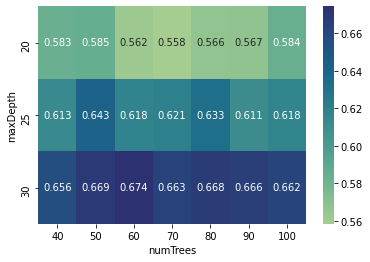

In [0]:
s = sns.heatmap(heatmap_df, cmap="crest", annot=True, fmt=".3f")
s.set(xlabel='numTrees', ylabel='maxDepth')

### Use the Best Model to predict the Test Set

In [0]:
final_model = cvModel_rfc.bestModel
prediction = final_model.transform(test)

In [0]:
prediction.display()

_c0,id,Time of Creation,processed_sentence,tickers,manual label,label,words,words_ngram,features,rawPrediction,probability,prediction
10,ac95wl,2019-01-03 12:27,favor merging tickerplaceholder appl snappl,SNAP,Hold,0.0,"List(favor, merging, tickerplaceholder, appl, snappl)","List(favor, merging, tickerplaceholder, appl, snappl)","Map(vectorType -> sparse, length -> 3872, indices -> List(0, 1539), values -> List(1.0, 1.0))","Map(vectorType -> dense, length -> 3, values -> List(38.248796042408635, 15.825321539902129, 5.925882417689239))","Map(vectorType -> dense, length -> 3, values -> List(0.6374799340401439, 0.2637553589983688, 0.09876470696148733))",0.0
1008,cyzj75,2019-09-02 21:36,last economic news tracker wwwredditcomrwallstreetbetscommentscxdpzeconomicnewsforyourradaraug note minussign time eastern standard time monday september numberplaceholder time edt item previous consensus forecast actual minussign minussign minussign minussign minussign minussign italy manufacturing pmi numberplaceholder percentsign miss germany manufacturing pmi numberplaceholder miss numberplaceholder germany manufacturing pmi numberplaceholder change manufacturing pmi numberplaceholder miss numberplaceholder brazil manufacturing pmi minussign minussign minussign numberplaceholder numberplaceholder beat numberplaceholder korea gdp minussign qoq minussign numberplaceholder percentsign minussign minussign minussign numberplaceholder percentsign numberplaceholder percentsign miss numberplaceholder korea gdp minussign yoy percentsign minussign minussign minussign numberplaceholder percentsign numberplaceholder percentsign miss numberplaceholder china yuan valuation minussign minussign minussign minussign minussign minussign numberplaceholder lower australia retail sale percentsign numberplaceholder percentsign numberplaceholder percentsign minussign numberplaceholder percentsign miss tuesday september numberplaceholder time edt item previous consensus forecast actual minussign minussign minussign minussign minussign minussign australia tickerplaceholder interest rate percentsign numberplaceholder percentsign numberplaceholder percentsign numberplaceholder ppi mom minussign numberplaceholder percentsign numberplaceholder percentsign numberplaceholder percentsign numberplaceholder ppi yoy percentsign numberplaceholder percentsign numberplaceholder percentsign canada manufacturing pmi minussign minussign minussign numberplaceholder usa markit manufacturing pmi numberplaceholder usa ism manufacturing numberplaceholder usa construction spending minussign numberplaceholder percentsign numberplaceholder percentsign numberplaceholder percentsign numberplaceholder usa economic optimism minussign minussign minussign numberplaceholder numberplaceholder usa total vehicle sale august minussign minussign minussign numberplaceholder usa federal reserve boston president eric rosengren speech minussign minussign minussign minussign minussign minussign minussign minussign minussign minussign minussign minussign,RBA,Hold,0.0,"List(last, economic, news, tracker, wwwredditcomrwallstreetbetscommentscxdpzeconomicnewsforyourradaraug, note, minussign, time, eastern, standard, time, monday, september, numberplaceholder, time, edt, item, previous, consensus, forecast, actual, minussign, minussign, minussign, minussign, minussign, minussign, italy, manufacturing, pmi, numberplaceholder, percentsign, miss, germany, manufacturing, pmi, numberplaceholder, miss, numberplaceholder, germany, manufacturing, pmi, numberplaceholder, change, manufacturing, pmi, numberplaceholder, miss, numberplaceholder, brazil, manufacturing, pmi, minussign, minussign, minussign, numberplaceholder, numberplaceholder, beat, numberplaceholder, korea, gdp, minussign, qoq, minussign, numberplaceholder, percentsign, minussign, minussign, minussign, numberplaceholder, percentsign, numberplaceholder, percentsign, miss, numberplaceholder, korea, gdp, minussign, yoy, percentsign, minussign, minussign, minussign,

In [0]:
from sklearn.metrics import classification_report
pandDF = prediction.select(prediction.label, prediction.prediction).toPandas()
print(classification_report(pandDF['label'], pandDF['prediction']))

              precision    recall  f1-score   support

         0.0       0.74      0.98      0.84       176
         1.0       0.88      0.51      0.65        86
         2.0       0.78      0.23      0.35        31

    accuracy                           0.76       293
   macro avg       0.80      0.57      0.61       293
weighted avg       0.78      0.76      0.73       293



### Use the Best Model to predict the Unlabelled Data

In [0]:
df_tolabel = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/ardit.baboci@ucalgary.ca/unlabelled_data_final.csv")
df_tolabel.display()

_c0,id,Time of Creation,processed_sentence,tickers
22,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder report earnings january,BAC
23,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign march dollarsign numberplaceholder call,BUD
24,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign june dollarsign numberplaceholder call,SQ
25,adavc8,2019-01-06 15:44,someone expecting dollarsign tickerplaceholder pop numberplaceholder percentsign next half year,SQ
26,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign january numberplaceholder dollarsign numberplaceholder call,CZR
27,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign july dollarsign numberplaceholder call,AVGO
29,adzu7e,2019-01-08 15:33,update tickerplaceholder redappleemoji,AAPL
30,advaxs,2019-01-08 8:32,tickerplaceholder numberplaceholder,RTX
31,aduqks,2019-01-08 7:35,dollarsign tickerplaceholder stay green another complete day actually run car tree,MU
32,adtr8y,2019-01-08 5:31,united state future slightly elevated minussign china trade talk wrap new stock exchange formed compete nyse nasdaq member exchange memx formed bank america charles schwab fidelity tickerplaceholder four financial firm,UBS


In [0]:
full_result = final_model.transform(df_tolabel)
full_result = full_result.drop("words")
full_result = full_result.drop("words_ngram")
full_result = full_result.drop("features")
full_result = full_result.drop("rawPrediction")
full_result = full_result.drop("probability")
full_result.display()

_c0,id,Time of Creation,processed_sentence,tickers,prediction
22,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder report earnings january,BAC,0.0
23,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign march dollarsign numberplaceholder call,BUD,1.0
24,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign june dollarsign numberplaceholder call,SQ,1.0
25,adavc8,2019-01-06 15:44,someone expecting dollarsign tickerplaceholder pop numberplaceholder percentsign next half year,SQ,0.0
26,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign january numberplaceholder dollarsign numberplaceholder call,CZR,1.0
27,adavc8,2019-01-06 15:44,dollarsign tickerplaceholder minussign buyer dollarsign july dollarsign numberplaceholder call,AVGO,1.0
29,adzu7e,2019-01-08 15:33,update tickerplaceholder redappleemoji,AAPL,0.0
30,advaxs,2019-01-08 8:32,tickerplaceholder numberplaceholder,RTX,0.0
31,aduqks,2019-01-08 7:35,dollarsign tickerplaceholder stay green another complete day actually run car tree,MU,0.0
32,adtr8y,2019-01-08 5:31,united state future slightly elevated minussign china trade talk wrap new stock exchange formed compete nyse nasdaq member exchange memx formed bank america charles schwab fidelity tickerplaceholder four financial firm,UBS,0.0
